In [5]:
import pandas as pd
import numpy as np
import seaborn as sns
import gc
import os
import time 

from scipy.stats import mode
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.metrics import accuracy_score

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras import backend as K
from keras.utils import np_utils
from keras.utils.vis_utils import plot_model
import matplotlib.pyplot as plt
import tensorflow as tf

In [6]:
import matplotlib.cm as cm
from IPython.display import Image, display

import warnings
warnings.filterwarnings("ignore")

In [7]:
from IPython.core.magic import (register_line_cell_magic)

@register_line_cell_magic
def skip(line, cell = None):
    if eval(line):
        print("cell skipped - not exectuted")
        return 
    get_ipython().ex(cell)

In [8]:
cfg = {
    'TARGET' : 'target',
    'N_FOLDS': 10,
    'RANDOM' : 42,
    'SCORING' : 'accuracy',
    'PROD' : True
}

In [11]:
test = pd.read_csv("./Dataset/test.csv", index_col = 'row_id')
train = pd.read_csv("./Dataset/train.csv", index_col = 'row_id')
sub_df = pd.read_csv("./Dataset/sample_submission.csv")

train.drop_duplicates(keep = 'first', inplace = True)
train = train.reset_index(drop = True)
test = test.reset_index(drop = True)

target = train.target
num_classes = target.nunique()

FEATURES = [col for col in train.columns if col not in ['target']]

In [12]:
scaler = MinMaxScaler()
train_df = pd.DataFrame(scaler.fit_transform(train[FEATURES]), columns=FEATURES)
test_df = pd.DataFrame(scaler.transform(test[FEATURES]), columns = FEATURES)

lb = LabelEncoder()
enc_target = lb.fit_transform(target)
train_df['target_enc'] = enc_target
train['target_enc'] = enc_target
train_df['target'] = target

In [13]:
img_rows = 13
img_cols = 22

In [14]:
def plot_bacteria(images, labels, indexes):
    num_row = 10
    num_col = 5

    fig, axes = plt.subplots(num_row, num_col, constrained_layout = True, sharex = True, sharey= True, figsize = (3*num_col, 2* num_row))

    for i in range(len(images)):
        ax = axes[i//num_col, i%num_col]
        image = images[i].reshape(img_rows, img_cols, 1)
        ax.imshow(image, cmap = 'Spectral')
        ax.set_title(f'{labels[i]}\n{indexes[i]}')
        plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.1, hspace=0.5)
    plt.show()

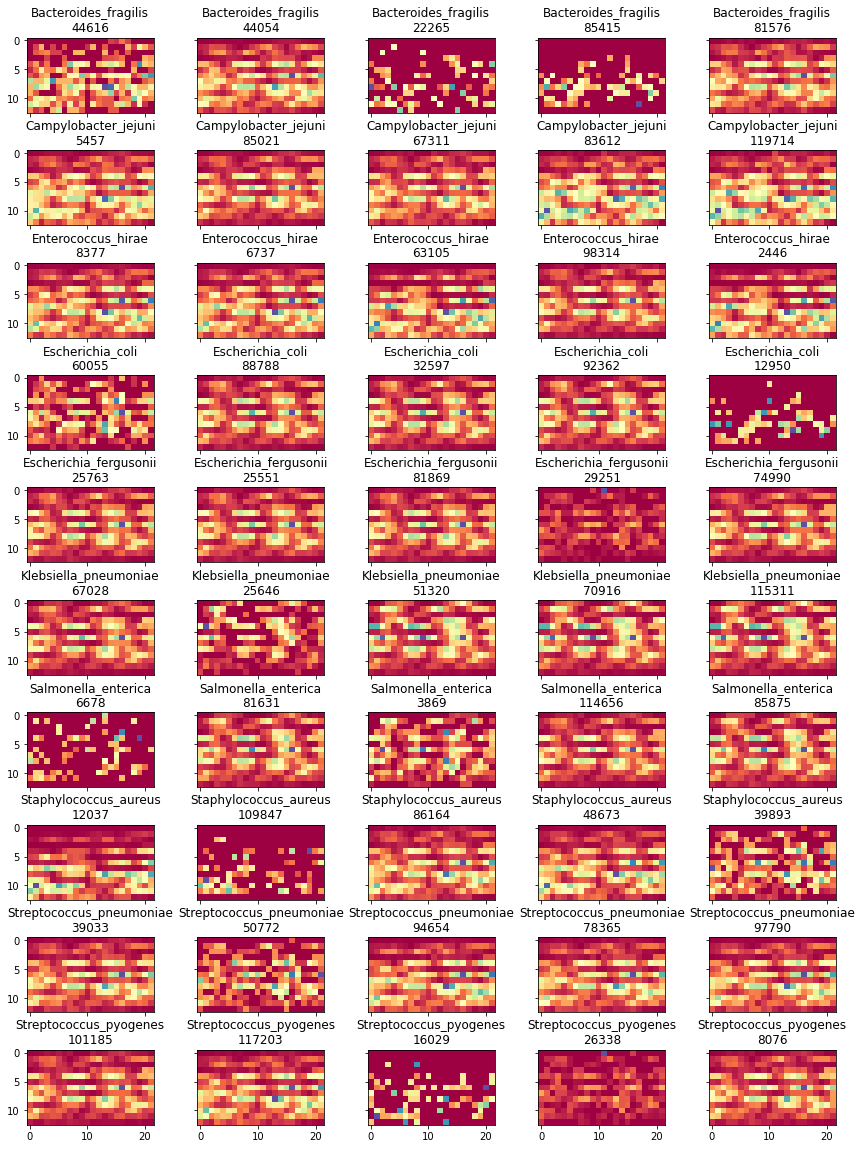

In [16]:
images = train_df.groupby("target").sample(5).drop(["target_enc"], axis = 1)
labels = images.target.values
indexes = images.index.values
images = images[FEATURES].values.reshape(images.shape[0], img_rows, img_cols, 1).astype('float32')

plot_bacteria(images, labels, indexes)

In [17]:
train_df.target.value_counts()

Bacteroides_fragilis        12522
Campylobacter_jejuni        12469
Klebsiella_pneumoniae       12420
Streptococcus_pneumoniae    12416
Staphylococcus_aureus       12415
Streptococcus_pyogenes      12406
Salmonella_enterica         12390
Enterococcus_hirae          12373
Escherichia_coli            12297
Escherichia_fergusonii      12285
Name: target, dtype: int64

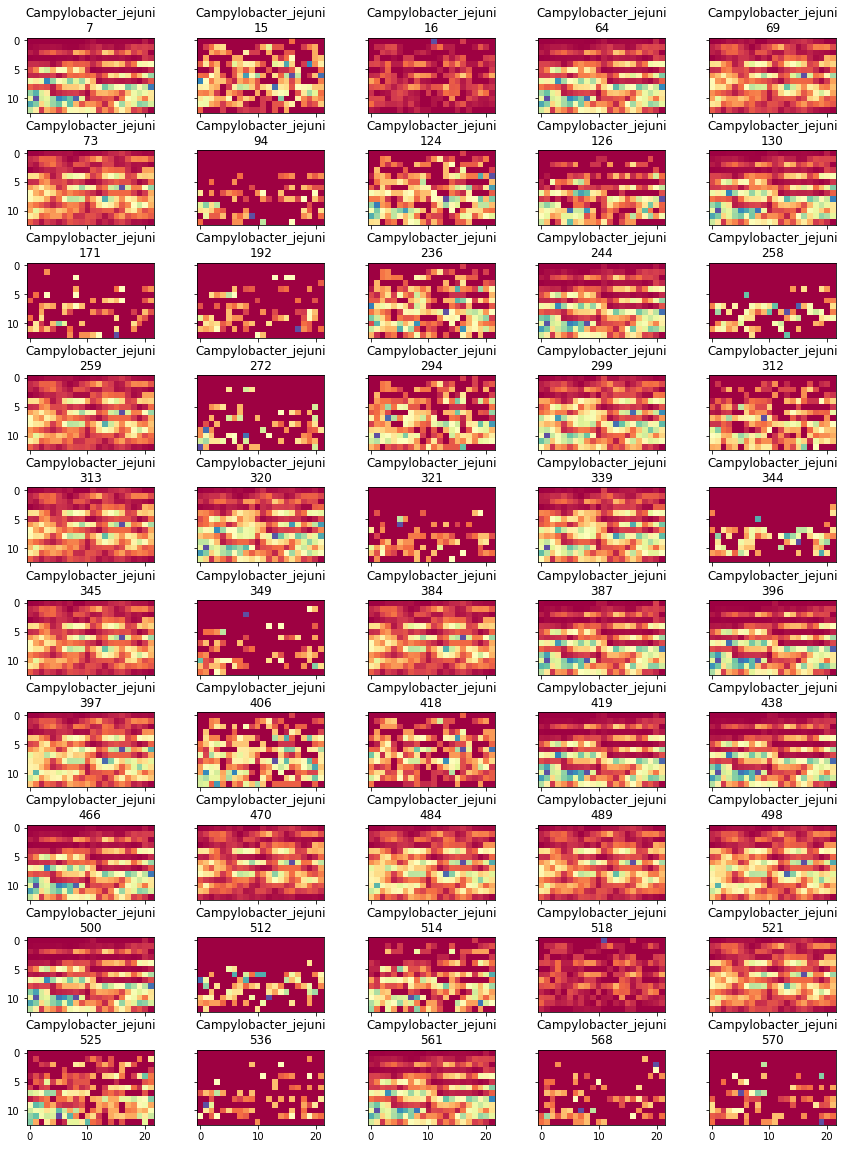

In [19]:
images = train_df.query("target == 'Campylobacter_jejuni'").sort_index()[:50].drop(["target_enc"], axis = 1)
labels = images.target.values
indexes = images.index.values
images = images[FEATURES].values.reshape(images.shape[0], img_rows, img_cols, 1).astype('float32')

plot_bacteria(images, labels, indexes)

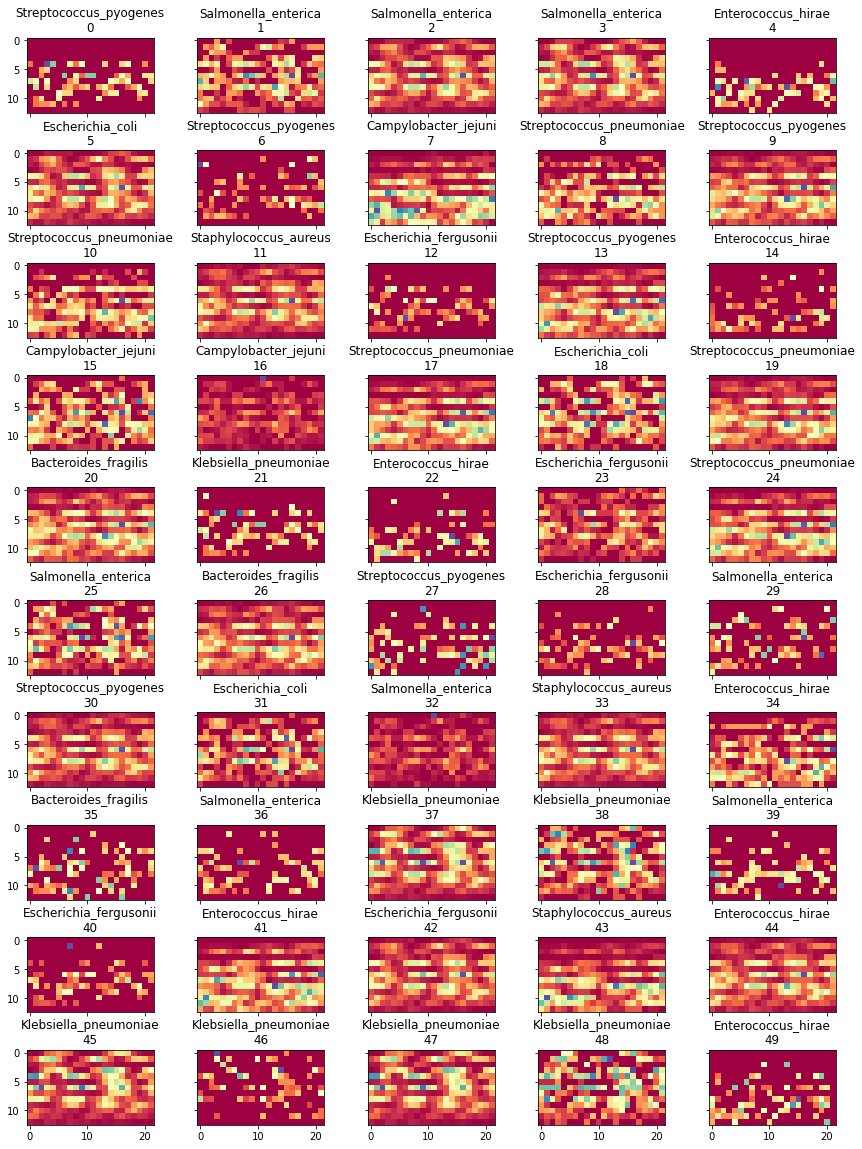

In [22]:
images = train_df.sort_index()[:50].drop(["target_enc"], axis = 1)
labels = images.target.values
indexes = images.index.values
images = images[FEATURES].values.reshape(images.shape[0], img_rows, img_cols, 1).astype('float32')

plot_bacteria(images, labels, indexes)

In [23]:
batch_size = 512
epochs = 100
input_shape = (img_rows, img_cols, 1)

In [24]:
def get_model():
    model = Sequential()
    x = Conv2D(128, kernel_size=(3,3), padding='same', activation='swish', input_shape = input_shape, kernel_initializer= 'he_uniform')
    model.add(x)
    model.add(Conv2D(64,(3,3), padding='same', activation='swish', kernel_initializer='he_uniform'))
    model.add(Dropout(0.2))
    model.add(Conv2D(64,(3,3), padding='same', activation='swish', kernel_initializer='he_uniform', name = 'conv_last'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(128, activation='swish', kernel_initializer='he_uniform'))
    model.add(Dropout(0.2))
    model.add(Dense(64, activation='swish', kernel_initializer='he_uniform'))
    model.add(Dense(32, activation='swish', kernel_initializer='he_uniform'))
    model.add(Dense(num_classes, activation='softmax'))

    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer= tf.keras.optimizers.Adam(learning_rate=0.001),
                  metrics=['accuracy'])
    
    return model, x

In [30]:
!pip install pydot 
!pip install graphviz

You should consider upgrading via the 'c:\python3\python.exe -m pip install --upgrade pip' command.
You should consider upgrading via the 'c:\python3\python.exe -m pip install --upgrade pip' command.


In [31]:
model_global, _ = get_model()

In [34]:
oof_preds = np.zeros((len(train_df), 1))
oof_proba = np.zeros((len(train_df), num_classes))
test_proba = np.zeros((len(test), num_classes))
test_preds = []
fold_scores = []
x = None #This is only for NN filter and Grad-CAM visualizations

kf = StratifiedKFold(n_splits = cfg['N_FOLDS'], random_state = cfg['RANDOM'])
print(f"Start CV model - {cfg['N_FOLDS']} for folds")

for folds, (train_idx, val_idx) in enumerate (kf.split(train, train.target_enc)):
    X_train, y_train = train[FEATURES].iloc[train_idx], train[['target_enc']].iloc[train_idx]
    X_val, y_val = train[FEATURES].iloc[val_idx], train [['target_enc']].iloc[val_idx]

    scaler = MinMaxScaler()
    X_train = scaler.fit_transform(X_train)
    X_val = scaler.transform(X_val)
    X_test = scaler.transform(test[FEATURES].values)

     # in fold data transformation -> convert to images
    X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1).astype('float32')
    X_val = X_val.reshape(X_val.shape[0], img_rows, img_cols, 1).astype('float32')
    X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1).astype('float32')
    
    # in fold target one hot encoding 
    enc = OneHotEncoder(categories = 'auto', drop = None, sparse = False)
    y_train = enc.fit_transform(y_train)
    y_val = enc.transform(y_val) 
    
    model, conv = get_model()
    
    es = tf.keras.callbacks.EarlyStopping(monitor = 'val_accuracy', min_delta = 0.00001, 
                                          patience = 6, verbose = 0, mode = 'max', baseline=None, 
                                          restore_best_weights=True)

    plateau = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_accuracy', 
                                                   factor = 0.04, patience = 5, 
                                                   verbose = 0, mode = 'max')

    history = model.fit(X_train, y_train,
                    batch_size = batch_size,
                    epochs = epochs,
                    verbose = 0,
                    validation_data = (X_val, y_val),
                    callbacks = [es, plateau])
    
    val_score = model.evaluate(X_val, y_val, verbose=0)
    print(f"   FOLD: {fold + 1} - accuracy on val set: ", val_score[1])
    
    fold_scores.append(history)
    oof_preds[val_idx, 0] = np.argmax(model.predict(X_val), axis = -1)
    oof_proba[val_idx, :] = model.predict(X_val)
    
    test_preds.append(np.argmax(model.predict(X_test), axis = -1))
    test_proba[: , :] += model.predict(X_test)
    
    # Save last model for filter/grad-CAM visualization
    if fold == cfg['N_FOLDS'] - 1:
        model_global = model
        x = conv
    else:
        del model, val_score, es, plateau
        gc.collect()

test_proba = test_proba / cfg['N_FOLDS']

oof_score = accuracy_score(train_df.target_enc.values, oof_preds)
print(f"OOF accuracy: {oof_score}")






ValueError: Setting a random_state has no effect since shuffle is False. You should leave random_state to its default (None), or set shuffle=True.